In [1]:
periodo = 'pandemia'

# Importe as bibliotecas necessárias

In [2]:
%matplotlib inline
from IPython.display import clear_output
import tqdm
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree._classes import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors._classification import KNeighborsClassifier
from sklearn.neural_network._multilayer_perceptron import MLPClassifier
from sklearn.linear_model._logistic import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
#from yellowbrick.style.colors import resolve_colors
from sklearn.model_selection._validation import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from unidecode import unidecode
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.decomposition import PCA
import pickle
#import statsmodels.api as sm
import platform 
np.random.seed(42)

In [3]:
def strfdelta(tdelta, fmt="{hours}:{minutes}:{seconds}"):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [4]:
def limparTela():
    
    plt = platform.system()
    
    if plt == "Windows":
        clear = lambda: os.system('cls')
        clear()
    elif plt == "Linux":
        print("Your system is Linux")
        clear = lambda: os.system('clear')
        clear()
    else:
        print("Unidentified system")

# Carregando Base de dados

In [5]:
df = pd.read_csv(f'twitterbase_{periodo}.csv', sep=';')
df.head()

,volumeTweets_media,volumeTweets_variancia,volumeTweets_mediaMovelPonterada,volumeTweets_entropia,indiceInsonia_media,indiceInsonia_variancia,indiceInsonia_mediaMovelPonterada,indiceInsonia_entropia,pronome1Pessoa_media,pronome1Pessoa_variancia,...,links_entropia,midia_media,midia_variancia,midia_mediaMovelPonterada,midia_entropia,curtidas_media,curtidas_variancia,curtidas_mediaMovelPonterada,curtidas_entropia,classe
0,0.291005,0.587274,2.043956,0.651770,0.085979,0.080240,0.592033,0.309788,0.111111,0.268078,...,0.191444,0.111111,0.194004,0.741758,0.329227,0.174603,1.900731,1.137363,0.246161,depressao
1,4.523810,28.701814,31.454545,2.429842,0.942526,0.623469,6.755375,2.050928,1.333333,4.269841,...,0.729340,0.000000,0.000000,0.000000,0.000000,3.369048,28.423328,24.142857,2.111950,depressao
2,3.780269,176.637817,23.240741,1.897887,0.655502,1.126668,4.608926,1.508046,0.381166,1.330049,...,0.386422,0.152466,0.550745,0.884259,0.370268,11.847534,7445.788413,80.023148,1.844651,depressao
3,1.036585,3.054759,7.285360,1.364078,0.349553,0.747253,2.449669,0.818067,0.312195,0.761071,...,0.268973,0.051220,0.068108,0.362283,0.195190,0.331707,0.816800,2.310174,0.673331,depressao
4,1.327869,0.799606,9.443182,1.267385,0.699454,0.860492,5.022727,1.172748,0.060109,0.089283,...,0.000000,0.010929,0.010810,0.045455,0.060228,0.202186,0.368957,1.437500,0.507957,controle


# Codificando a variável categórica

In [6]:
label_encoder = LabelEncoder()
df['classe'] = label_encoder.fit_transform(df['classe']).astype('float64')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70370 entries, 0 to 70369
Data columns (total 61 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   volumeTweets_media                              70370 non-null  float64
 1   volumeTweets_variancia                          70370 non-null  float64
 2   volumeTweets_mediaMovelPonterada                70370 non-null  float64
 3   volumeTweets_entropia                           70370 non-null  float64
 4   indiceInsonia_media                             70370 non-null  float64
 5   indiceInsonia_variancia                         70370 non-null  float64
 6   indiceInsonia_mediaMovelPonterada               70370 non-null  float64
 7   indiceInsonia_entropia                          70370 non-null  float64
 8   pronome1Pessoa_media                            70370 non-null  float64
 9   pronome1Pessoa_variancia               

# Preparando os dados

In [8]:
def train_val_test(X, y, train_ratio, val_ratio, test_ratio):
    assert sum([train_ratio, test_ratio, val_ratio])==1.0, "wrong given ratio, all ratios have to sum to 1.0"
    assert X.shape[0]==len(y), "X and y shape mismatch"

    ind_train = int(round(X.shape[0]*train_ratio))
    ind_test = int(round(X.shape[0]*(train_ratio+test_ratio)))

    X_train = X[:ind_train]
    X_test = X[ind_train:ind_test]
    X_val = X[ind_test:]

    y_train = y[:ind_train]
    y_test = y[ind_train:ind_test]
    y_val = y[ind_test:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
def plotarMatrizesConfusoes(nome_classificador, matriz_confusao_relativa):
    plt.figure(figsize=(10, 8))
    plt.title(f'Matriz de confusão {nome_classificador}')
    sns.heatmap(matriz_confusao_relativa, linewidths=.5, cmap='coolwarm', annot=True, fmt='.1%', vmin=0, vmax=1,
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.savefig(f'matrizConfusao_{nome_classificador}_{periodo}.png', bbox_inches='tight', format="png")
    plt.show()
    plt.close()

In [10]:


def avaliacao(classificador, predicao, x, y, nome_classificador):
    '''
    Computa as mericas de avaliação dos clasficadores
    '''
        
    precisao = precision_score(y, predicao)
    revocacao = recall_score(y, predicao)
    f1score = f1_score(y, predicao)
    acuracia = accuracy_score(y, predicao)
    return [precisao, revocacao, f1score, acuracia]
    
def modeloML(model, x, x_train, y_train, x_val, y_val, nome_classificador):
    clear_output()
    print(nome_classificador)
    
    model.fit(x_train, y_train)
    predicao = cross_val_predict(model, x_val, y_val, cv=cv)
    #predicao = GridSearchCV(model, {}, cv=cv, verbose=10, n_jobs=3).fit(x_train, y_train).predict(x_val)
    #predicao = cross_val_predict(GridSearchCV(model, {}, cv=cv, verbose=10).fit(x_train, y_train).best_estimator_, x_val, y_val, cv=cv)
    resultados = avaliacao(model, predicao, x_val, y_val, nome_classificador)
    df_resultados.loc[nome_classificador][f'exp_teste_precisao'] = round(resultados[0] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_recall'] = round(resultados[1] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_f1_score'] = round(resultados[2] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_acuracia'] = round(resultados[3] * 100, 1)
    
    
def modeloMLTeste(model, x, x_train, y_train, x_val, y_val, nome_classificador):
    clear_output()
    print(nome_classificador)
    
    predicao = cross_val_predict(model, x_val, y_val, cv=cv)
    #predicao = GridSearchCV(model, {}, cv=cv, verbose=10, n_jobs=3).fit(x_train, y_train).predict(x_val)
    #predicao = cross_val_predict(GridSearchCV(model, {}, cv=cv, verbose=10).fit(x_train, y_train).best_estimator_, x_val, y_val, cv=cv)
    resultados = avaliacao(model, predicao, x_val, y_val, nome_classificador)
    df_resultados.loc[nome_classificador][f'exp_teste_precisao'] = round(resultados[0] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_recall'] = round(resultados[1] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_f1_score'] = round(resultados[2] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_acuracia'] = round(resultados[3] * 100, 1)
    
    matriz_confusao = confusion_matrix(y_val, predicao)
    matriz_confusao_relativa = matriz_confusao / matriz_confusao.sum(axis=1, keepdims=True)
    
    plotarMatrizesConfusoes(nome_classificador, matriz_confusao_relativa)

In [11]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
zscore = StandardScaler()

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

In [12]:
if not os.path.exists(f'df_resultados_{periodo}_novosAtributos_teste_f1Score.xlsx'):
    metricas = ['acuracia', 'precisao', 'recall', 'f1_score']
    colunas = [f'exp_teste_{i}' for i in metricas]
    #metricas = [f'{metrica} Exp {numero}' for numero in range(1, 2) for metrica in metricas]
    modelos = ['Gradient Boosting', 'Perceptron Multicamadas']
    df_resultados = pd.DataFrame(columns=colunas, index=modelos)
    df_resultados.index.name = "Model"
else:
    df_resultados = pd.read_excel(f'df_resultados_{periodo}_novosAtributos_teste_f1Score.xlsx', index_col=0)
    

In [13]:
df_resultados

,exp_teste_acuracia,exp_teste_precisao,exp_teste_recall,exp_teste_f1_score
Model,,,,
Gradient Boosting,74.2,73.2,87.8,79.9
Perceptron Multicamadas,74.2,74.2,85.4,79.4


In [14]:
def executar(x, y):

    x_train, y_train, x_val, y_val, x_test, y_test = train_val_test(x, y, train_ratio, validation_ratio, test_ratio)
    
    gradientBoosting = GradientBoostingClassifier(random_state=42, n_estimators=100, verbose=10)
    perceptronMulticamadas = MLPClassifier(random_state=42, hidden_layer_sizes=(10,30,10), max_iter=100, verbose=10)
    
    modeloML(perceptronMulticamadas, x, x_train, y_train, x_val, y_val, 'Perceptron Multicamadas')
    modeloML(gradientBoosting, x, x_train, y_train, x_val, y_val, 'Gradient Boosting')
    
    modeloMLTeste(perceptronMulticamadas, x, x_train, y_train, x_test, y_test, 'Perceptron Multicamadas')
    modeloMLTeste(gradientBoosting, x, x_train, y_train, x_test, y_test, 'Gradient Boosting')

In [15]:
choq = ['volumeTweets_media', 'volumeTweets_mediaMovelPonterada', 
        'indiceInsonia_variancia', 'indiceInsonia_mediaMovelPonterada',
        'pronome1Pessoa_media', 'pronome1Pessoa_variancia', 
        'pronome2Pessoa_mediaMovelPonterada', 'pronome2Pessoa_entropia',
        'pronome3Pessoa_media', 'pronome3Pessoa_mediaMovelPonterada',
        'valencia_mediaMovelPonterada', 'valencia_entropia', 
        'ativacao_mediaMovelPonterada', 'ativacao_entropia', 
        'termosDepressivos_variancia', 'termosDepressivos_mediaMovelPonterada',
        'grafoSocial_variancia', 'grafoSocial_mediaMovelPonterada',
        'medicamentosAntiDepressivo_media', 'medicamentosAntiDepressivo_mediaMovelPonterada']
caracteresOrientais = ['caracteresOrientais_variancia', 'caracteresOrientais_mediaMovelPonterada']
emojis = ['emojis_variancia', 'emojis_entropia']
links = ['links_mediaMovelPonterada', 'links_entropia']
midia = ['midia_variancia', 'midia_mediaMovelPonterada']
curtidas = ['curtidas_media', 'curtidas_mediaMovelPonterada']

In [16]:
#gb
exp = choq# + caracteresOrientais + midia + emojis + curtidas + links

exp

['volumeTweets_media',
 'volumeTweets_mediaMovelPonterada',
 'indiceInsonia_variancia',
 'indiceInsonia_mediaMovelPonterada',
 'pronome1Pessoa_media',
 'pronome1Pessoa_variancia',
 'pronome2Pessoa_mediaMovelPonterada',
 'pronome2Pessoa_entropia',
 'pronome3Pessoa_media',
 'pronome3Pessoa_mediaMovelPonterada',
 'valencia_mediaMovelPonterada',
 'valencia_entropia',
 'ativacao_mediaMovelPonterada',
 'ativacao_entropia',
 'termosDepressivos_variancia',
 'termosDepressivos_mediaMovelPonterada',
 'grafoSocial_variancia',
 'grafoSocial_mediaMovelPonterada',
 'medicamentosAntiDepressivo_media',
 'medicamentosAntiDepressivo_mediaMovelPonterada']

Gradient Boosting
      Iter       Train Loss   Remaining Time 
         1           1.3162            7.03s
         2           1.2798            6.54s
         3           1.2496            6.67s
         4           1.2239            6.47s
         5           1.2028            6.31s
         6           1.1847            6.18s
         7           1.1683            6.25s
         8           1.1550            6.13s
         9           1.1425            6.02s
        10           1.1318            5.92s
        11           1.1218            5.92s
        12           1.1132            5.86s
        13           1.1056            5.77s
        14           1.0989            5.86s
        15           1.0921            5.87s
        16           1.0865            5.76s
        17           1.0810            5.82s
        18           1.0760            5.78s
        19           1.0713            5.74s
        20           1.0669            5.77s
        21           1.0633         

        81           0.9584            1.32s
        82           0.9569            1.25s
        83           0.9562            1.18s
        84           0.9551            1.11s
        85           0.9545            1.04s
        86           0.9535            0.97s
        87           0.9527            0.90s
        88           0.9515            0.83s
        89           0.9505            0.76s
        90           0.9494            0.69s
        91           0.9488            0.62s
        92           0.9479            0.55s
        93           0.9467            0.48s
        94           0.9454            0.41s
        95           0.9442            0.34s
        96           0.9429            0.28s
        97           0.9421            0.21s
        98           0.9406            0.14s
        99           0.9395            0.07s
       100           0.9385            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3156            6.19s
         

        62           0.9811            2.50s
        63           0.9801            2.43s
        64           0.9786            2.37s
        65           0.9777            2.31s
        66           0.9769            2.24s
        67           0.9754            2.17s
        68           0.9744            2.10s
        69           0.9727            2.04s
        70           0.9719            1.97s
        71           0.9706            1.91s
        72           0.9696            1.84s
        73           0.9688            1.78s
        74           0.9678            1.71s
        75           0.9661            1.64s
        76           0.9650            1.58s
        77           0.9641            1.52s
        78           0.9629            1.45s
        79           0.9623            1.38s
        80           0.9613            1.32s
        81           0.9605            1.25s
        82           0.9594            1.19s
        83           0.9585            1.12s
        84

        44           1.0085            3.70s
        45           1.0072            3.64s
        46           1.0056            3.57s
        47           1.0042            3.51s
        48           1.0028            3.44s
        49           1.0012            3.37s
        50           0.9998            3.31s
        51           0.9980            3.24s
        52           0.9967            3.17s
        53           0.9958            3.10s
        54           0.9946            3.05s
        55           0.9935            2.98s
        56           0.9922            2.91s
        57           0.9905            2.84s
        58           0.9893            2.78s
        59           0.9884            2.71s
        60           0.9876            2.64s
        61           0.9864            2.57s
        62           0.9858            2.52s
        63           0.9846            2.45s
        64           0.9832            2.38s
        65           0.9816            2.31s
        66

        25           1.0439            4.92s
        26           1.0402            4.84s
        27           1.0371            4.77s
        28           1.0342            4.74s
        29           1.0314            4.67s
        30           1.0295            4.59s
        31           1.0272            4.52s
        32           1.0249            4.47s
        33           1.0223            4.40s
        34           1.0202            4.33s
        35           1.0183            4.29s
        36           1.0163            4.22s
        37           1.0150            4.15s
        38           1.0134            4.07s
        39           1.0115            4.00s
        40           1.0103            3.96s
        41           1.0087            3.89s
        42           1.0074            3.82s
        43           1.0063            3.75s
        44           1.0041            3.68s
        45           1.0025            3.63s
        46           1.0012            3.56s
        47

         7           1.1649            6.26s
         8           1.1511            6.13s
         9           1.1389            6.02s
        10           1.1283            5.92s
        11           1.1191            5.83s
        12           1.1104            5.74s
        13           1.1023            5.66s
        14           1.0955            5.69s
        15           1.0896            5.59s
        16           1.0834            5.51s
        17           1.0780            5.43s
        18           1.0740            5.41s
        19           1.0691            5.33s
        20           1.0640            5.25s
        21           1.0600            5.17s
        22           1.0562            5.10s
        23           1.0526            5.02s
        24           1.0494            5.00s
        25           1.0464            4.93s
        26           1.0431            4.85s
        27           1.0403            4.77s
        28           1.0376            4.70s
        29

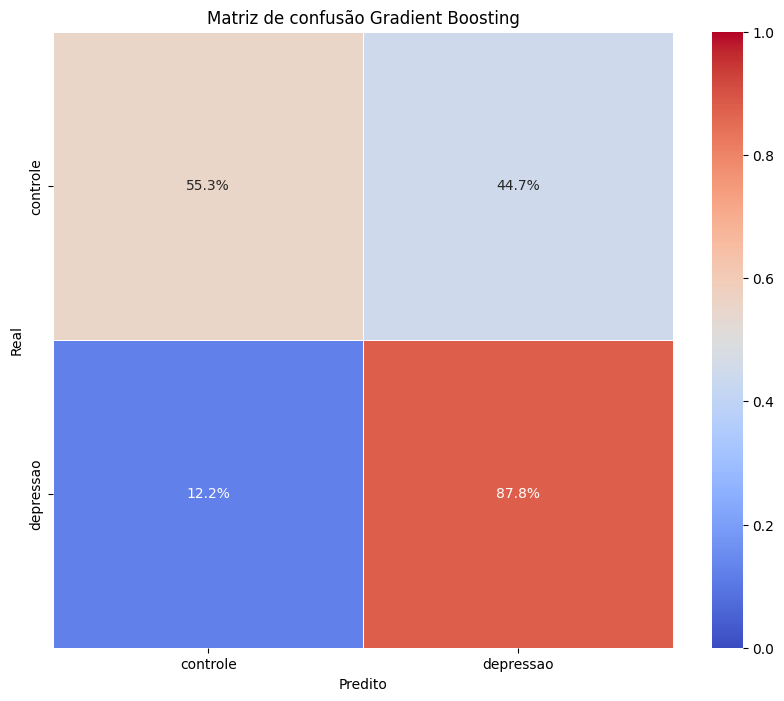

In [17]:
x = df[exp].copy()
y = df['classe'].copy()
    #selectKBest = SelectKBest(chi2, k=int(x.shape[1] * 0.5)).fit(x, y)
    #x_new = selectKBest.transform(x)
x_new = zscore.fit_transform(x)
    #x = PCA(n_components=0.95, svd_solver='full', random_state=42).fit_transform(x)

    
executar(x_new, y)

df_resultados_round = df_resultados.copy()
#df_resultados_round.to_excel(f'df_resultados_{periodo}_novosAtributos_teste_f1Score.xlsx', encoding='utf-8')

In [18]:
#df_resultados_round